In [3]:
import time

import utils
#import models
import pickle
import averaging_models as am

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import  MinMaxScaler, Normalizer, RobustScaler, StandardScaler

import matplotlib.pyplot as plt
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdReducedGraphs import GenerateErGFingerprintForReducedGraph
from rdkit.Chem import AllChem, rdReducedGraphs
from rdkit.Chem import DataStructs
from rdkit import rdBase
import numpy as np
from rdkit.Chem import RDConfig


colors = ['#f25c9d', '#F2A25C', '#5B98A6', '#8BB63C']
path = 'f:/_phd/Docking_score/VDR/Data/'

In [4]:
df1 = pd.read_csv(path + "VDR_actives_decoys_ECR_plus_docking_results_plus_rank_1DB1_3KPZ.csv")
df2 = pd.read_csv(path + "VDR_VDRML_ECR_plus_docking_results_plus_rank_1DB1_3KPZ.csv")

In [5]:
df = pd.concat([df1, df2])
df = df.rename(columns={'smiles': 'smi'})
names_ds = df.columns[4:].to_list()

In [6]:
df = pd.concat([df1, df2])
df = df.rename(columns={'smiles': 'smi', 'id_conf': 'id'})

names = df.columns[2:].to_list()
names = ['id', 'smi', 'ECR_1DB1', 'ECR_3KPZ'] + names
names_ds = [n for n in names if 'rank' not in n]

df = df[names_ds]
names_ds = names_ds[5:]

df.shape

(17540, 16)

In [7]:
df.smi[0]

0    O[C@@H]1CC(C[C@@H](O)C1=C)=C\C=C/1\[C@@H]2CC[C...
0    O(CC(O)C(C)(C)C)c1ccc(cc1C)C(CC)(CC)c1ccc(NC(=...
Name: smi, dtype: object

# Normalization, sampling and fingerprints  

In [8]:
df_train = df.sample(n=17000)
mols = [Chem.MolFromSmiles(mol) for mol in list(df_train['smi'])]
ergfps = [rdReducedGraphs.GetErGFingerprint(mol) for mol in mols]
morgfps = [AllChem.GetMorganFingerprintAsBitVect(mol,1 , nBits=1024) for mol in mols]

In [9]:
scaler = MinMaxScaler()
df_train[names_ds] = scaler.fit_transform(df_train[names_ds])

In [11]:
pca = PCA(0.8)
path = 'd:\\_PHD\\pred_web\\models\\VDR\\'

pca.fit(morgfps)
morg_pca = pca.transform(morgfps) 

In [12]:
with open(path+'PCA_morgfps.pckl', 'wb') as f:
    pickle.dump(pca, f)

In [13]:
pca.fit(ergfps)
erg_pca = pca.transform(ergfps)
with open(path+'PCA_ergfps.pckl', 'wb') as f:
    pickle.dump(pca, f)

# modelling

In [14]:
import skopt
from numpy import mean
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn import decomposition
import argparse
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb
from timeit import default_timer as timer

# input vectors

In [12]:
#transform the distribution

In [16]:
names_ds = names_ds[1:]

In [17]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from scipy.stats import norm

plt.style.use('seaborn-white')
df_train_transformed = pd.DataFrame.copy(df_train)

# transform the data
for i, name in enumerate(names_ds):
    df_train_transformed[name] = df_train_transformed[name] + 0.00001
    df_train_transformed[name], _ = boxcox(df_train_transformed[name])

In [18]:
# plot transformed

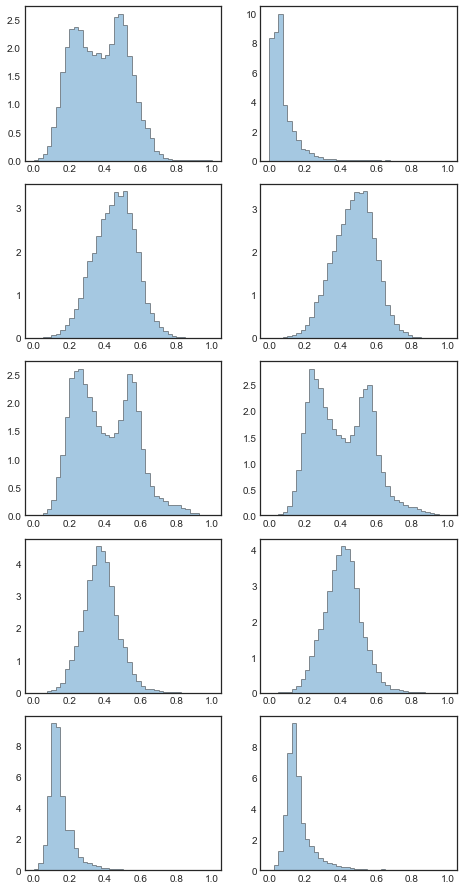

In [25]:
fig = plt.figure(figsize=(6,12)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.15, wspace=0.2) 
#df_train[names_ds] = scaler.inverse_transform(df_train[names_ds])
for i, name in enumerate(names_ds):
    ax = fig.add_subplot(5, 2, i+1)
    kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=40, ec="k")
    
    plt.hist(df_train[name], **kwargs)

In [27]:
df_scaled = df_train[names_ds]
df_scaled.to_csv(path+'vdr_df_scaled.csv')

In [54]:
df_inversed = pd.DataFrame.copy(df_train)
df_inversed[names_ds] = scaler.inverse_transform(df_train[names_ds])
df_inversed[names_ds[1]].hist(bins=40)
plt.title(names_ds[1])

ValueError: operands could not be broadcast together with shapes (35000,10) (12,) (35000,10) 

In [20]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdReducedGraphs import GenerateErGFingerprintForReducedGraph
from rdkit.Chem import AllChem, rdReducedGraphs
from rdkit.Chem import DataStructs
from rdkit import rdBase
import numpy as np
from rdkit.Chem import RDConfig

In [21]:
erg_pca.shape, morg_pca.shape

((17000, 23), (17000, 122))

In [22]:
i = 1
name = names_ds[i]
concat_fps = np.concatenate((erg_pca, morg_pca), 1)
x = np.array(concat_fps)
y = np.array(df_train[name], dtype=np.float32).ravel()
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.4, random_state=1)


#averaged_models = AveragingModels(models = (ENet, GBoost, KRR, ML))

#score = mse_cv(averaged_models)
#print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [64]:
ML.fit(trainX, trainY)

MLPRegressor(hidden_layer_sizes=(600, 400, 200, 50), random_state=1)

In [62]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, RF), meta_model=ML)
stacked_averaged_models.fit(trainX, trainY)
stacked_train_pred = stacked_averaged_models.predict(testX)

0.0011214496962531086

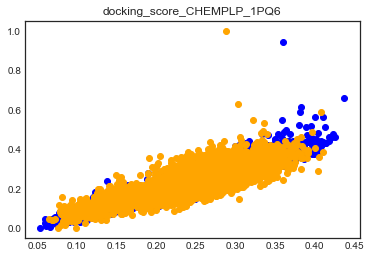

In [63]:
#model = ENet
#model.fit(trainX, trainY)
model = stacked_averaged_models

a = model.predict(trainX)
b = np.array(trainY, dtype=np.float32)
plt.scatter(a, b, color = 'blue')

a = model.predict(testX)
b = np.array(testY, dtype=np.float32) 
plt.scatter(a, b, color = 'orange')
plt.title(name)

mean_squared_error(a, b)

0.0011704202590280858

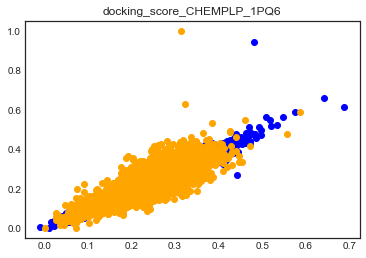

In [66]:
model = ML

a = model.predict(trainX)
b = np.array(trainY, dtype=np.float32)
plt.scatter(a, b, color = 'blue')

a = model.predict(testX)
b = np.array(testY, dtype=np.float32) 
plt.scatter(a, b, color = 'orange')
plt.title(name)

mean_squared_error(a, b)

In [68]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, ML))
averaged_models.fit(trainX, trainY)

AveragingModels(models=(Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('elasticnet',
                                         ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                                    random_state=3))]),
                        GradientBoostingRegressor(learning_rate=0.05,
                                                  loss='huber', max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=15,
                                                  min_samples_split=10,
                                                  n_estimators=3000,
                                                  random_state=5),
                        KernelRidge(alpha=0.6, coef0=2.5, degree=2,
                                    kernel='polynomial'),
                        MLPRegressor(hidden_layer_sizes=(600, 400, 200, 50),
                   

0.00099676280940488

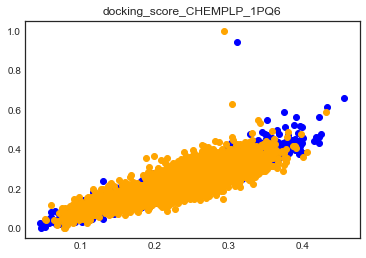

In [69]:
model = averaged_models

a = model.predict(trainX)
b = np.array(trainY, dtype=np.float32)
plt.scatter(a, b, color = 'blue')

a = model.predict(testX)
b = np.array(testY, dtype=np.float32) 
plt.scatter(a, b, color = 'orange')
plt.title(name)

mean_squared_error(a, b)

In [23]:
path = 'd:/_PHD/pred_web/models/VDR/'

x = np.array(concat_fps)

for i, name in enumerate(names_ds):    
    y = np.array(df_train[name], dtype=np.float32).ravel()
    
    trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.4, random_state=1)
    averaged_models = am.AveragingModels(models = (am.ENet, am.GBoost, am.KRR, am.ML))
    averaged_models.fit(trainX, trainY)
    
    averaged_models.save(path+f'VDR_{name}_aver_mod_boxcox.models')
    
    #with open(path+f'LXRB_{name}_aver_mod_boxcox.models', 'wb') as f:
    #    pickle.dump(averaged_models, f)
    

0.015682681435851515


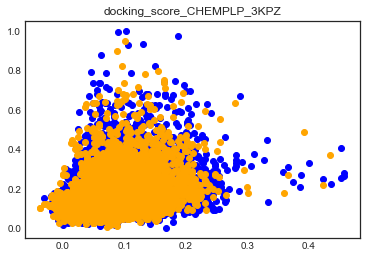

In [24]:
for i, name in enumerate(names_ds[1:2]):
    with open(path+f'VDR_{name}_aver_mod_boxcox.models', 'rb') as f:
        model = pickle.load(f)
        
    trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.4, random_state=1)

    a = model.predict(trainX)
    b = np.array(trainY, dtype=np.float32)
    plt.scatter(a, b, color = 'blue')

    a = model.predict(testX)
    b = np.array(testY, dtype=np.float32) 
    plt.scatter(a, b, color = 'orange')
    plt.title(name)

    print(mean_squared_error(a, b))

In [79]:
names_ds

['docking_score_CHEMPLP_1P8D',
 'docking_score_CHEMPLP_1PQ6',
 'docking_score_LondondG_1P8D',
 'docking_score_LondondG_1PQ6',
 'docking_score_ASE_1P8D',
 'docking_score_ASE_1PQ6',
 'docking_score_AdG_1P8D',
 'docking_score_AdG_1PQ6',
 'docking_score_AHB_1P8D',
 'docking_score_AHB_1PQ6']

In [96]:
ole = [np.array([1, 2 ]), np.array([1, 2 ])]
ole

[array([1, 2]), array([1, 2])]

In [88]:
a = list(ole.T)

In [91]:
a = np.reshape(ole, (2,-1))

In [95]:
test_df = pd.DataFrame([ole], columns=names_ds[:2])
test_df

ValueError: Must pass 2-d input

In [93]:
a

array([[1, 2],
       [1, 2]])

In [83]:
test_df = pd.DataFrame([], columns=names_ds[:2])